# Graphes : notions de base, parcours, distances

## Définitions

1. On appelle graphe (discret, fini) la donnée d'un couple $G = (V,E)$ où
- $V$ est un ensemble fini, dont les éléments sont appelés des sommets (_vertices_ en anglais);
- $E$ est un sous-ensemble de $V \times V$ (les arètes, ou _edges_).

Par commodité, on se ramènera fréquemment au cas $V = \{1 \dots, n\}$ ou $V = \{0, \dots, n-1\}$ selon les préférences.

2. Si $e = (v_1, v_2) \in E$ est une arète, on appelle $v_1$ l'origine (ou entrée) de $e$ et $v_2$ la fin (ou sortie) de $e$.

3. Un graphe $G = (V,E)$ est dit non orienté si $E$ est symétrique, i.e. si $(v_1, v_2) \in E \Leftrightarrow (v_2, v_1) \in E$. On note alors fréquemment $e = \{v_1, v_2\}$, sans ordre privilégié. Il est dit orienté sinon.

Dans toute la suite, on ne se préoccupera plus que de graphes non orientés.

4. On dit que deux somments $v_1, v_2 \in V$ sont _adjacents_ ou _voisins_ si $\{v_1,v_2\} \in E$.

5. Le _degré_ d'un sommet $v \in V$ est le nombre de sommets qui lui sont adjacents.

Un dessin valant mille mots, en voici un exemple.

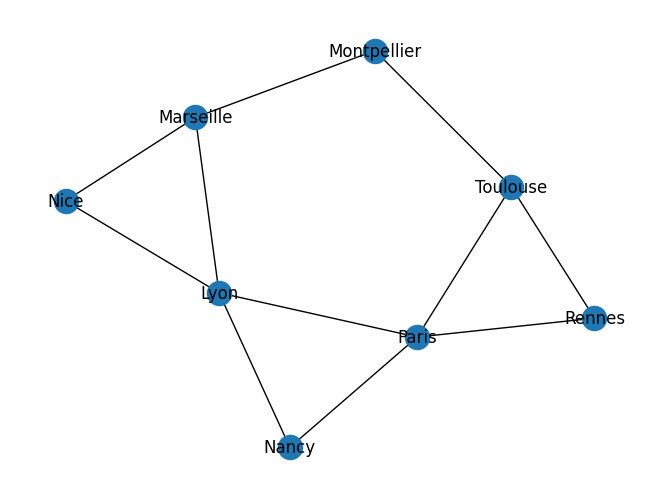

In [1]:
!pip install --quiet networkx

import networkx as nx
import matplotlib.pyplot as plt

def create_graph():
    G = nx.Graph()
    villes = ["Lyon","Marseille","Montpellier","Nancy","Nice","Paris","Rennes","Toulouse"]
    G.add_nodes_from(villes)

    G.add_edges_from([
        ("Lyon","Marseille"), ("Lyon","Nancy"), ("Lyon","Nice"), ("Lyon","Paris"),
        ("Marseille","Montpellier"), ("Marseille","Nice"),
        ("Montpellier","Toulouse"),
        ("Nancy","Paris"),
        ("Paris","Rennes"), ("Paris","Toulouse"),
        ("Rennes","Toulouse")
    ])
    return G

G = create_graph()
nx.draw(G, with_labels=True)

Il est à noter qu'un graphe est une représentation idéalisée et très simplifiée de relations de type voisinage ou distance entre objets. L'exactitude géographique est totalement secondaire.

## Représentations et implémentations de graphes

Nous verrons ici deux façons de représenter un graphe par des objets Python. Les deux approches ont leurs intérêts selon ce que l'on souhaite en faire.

### Matrices d'adjacence

Il s'agit d'une vision globale du graphe. On dresse une grande matrice de format $n \times n$, où $n$ est le nombre de sommets de $G$ et on remplit la case de coordonnées $(i,j)$ par $\mathbb{1}_{(i,j) \in E}$ (i.e. par $1$ si $(i,j)$ est une arète de $E$, $0$ sinon). La construction a un sens pour les graphes orientés comme non orientés et la matrice sera symétrique si et seulement si le graphe est non orienté.

L'inconvéinent majeur de cette méthode est que, en pratique, les graphes rencontrés ne sont pas _complets_, i.e. il n'est pas vrai que chaque sommet est relié à tous les autres. Ce fait se traduit par des matrices dites _creuses_, avec beaucoup de zéros. On stocke ainsi en mémoire une grande quantité d'informations inutiles, rendant les opérations matricielles inutilement coûteuses en calculs.

<!-- Insérer un exemple ici. -->

### Dictionnaire de voisins (ou listes d'adjacence)

On choisit ici une vision beaucoup plus locale dans l'esprit de notre graphe. On représente celui-ci par un dictionnaire ayant
- pour clés, les sommets du graphe;
- pour valeurs, les listes de sommets adjacents à la clé.

Cette représentation est efficace en mémoire, puisqu'on stocke uniquement les arètes dont on a réellement besoin. Là encore, le caractère non orienté du graphe peut se lire directement dans une forme de symétrie du dictionnaire le représentant (appartenance réciproque à la liste de voisins).

On illustre ci-dessous ces notions avec l'exemple du graphe de villes $G$ défini plus haut.

<!-- Insérer un exemple ici, avec le même graphe tant qu'à faire. -->

In [2]:
import numpy as np
from pprint import pprint

# Matrice d’adjacence
villes = list(G.nodes())
matrice = nx.to_numpy_array(G, nodelist=villes, dtype=int)
print("Matrice d'adjacence :")
print(np.array2string(matrice, separator=", "))

# Dictionnaire de voisins
voisins = {n: list(G.neighbors(n)) for n in G.nodes()}
print("\nDictionnaire de voisins :")
pprint(voisins, sort_dicts=True, width=80)

Matrice d'adjacence :
[[0, 1, 0, 1, 1, 1, 0, 0],
 [1, 0, 1, 0, 1, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 0, 1, 1, 0]]

Dictionnaire de voisins :
{'Lyon': ['Marseille', 'Nancy', 'Nice', 'Paris'],
 'Marseille': ['Lyon', 'Montpellier', 'Nice'],
 'Montpellier': ['Marseille', 'Toulouse'],
 'Nancy': ['Lyon', 'Paris'],
 'Nice': ['Lyon', 'Marseille'],
 'Paris': ['Lyon', 'Nancy', 'Rennes', 'Toulouse'],
 'Rennes': ['Paris', 'Toulouse'],
 'Toulouse': ['Montpellier', 'Paris', 'Rennes']}


## Algorithmes de parcours

### Généralités

Lorsqu'un graphe nous est donné, il peut être intéressant de déterminer certaines caractéristiques topologiques de celui-ci. Étant donné un sommet origine $v$, quels sommets peut-on atteindre en se servant uniquement des arètes du graphe (i.e. quelle est la composante connexe de $v$) ? Question subsidaiire, en combien de sauts, ou de temps, peut-on aller de $v$ vers n'importe quel autre sommet ?

Les deux algorithmes de parcours présentés répondent à la première question, tandis que l'algorithme de Dijkstra répond à la seconde.

### Parcours en largeur, en profondeur

Aussi appelé BFS et DFS respectivement, pour _breadth-first search_ et _depth-first search_. L'idée commune est, partant de $v$, explorer successivement les voisins de $v$, puis les voisins des voisins de $v$ non encore explorés et ainsi de suite jusqu'à épuiser les sommets accessibles.

Ces deux algorithmes se différencient, comme leur nom l'indique, sur la priorité donnée aux sommets. Le premier explore par cercles concentriques autour de $v$, le second cherche au contraire à aller loin le plus rapidement possible.

Dans tous les cas, il est nécessaire de trier les sommets entre
- ceux qui ont été explorés (et sont donc accessibles depuis $v$);
- ceux qui n'ont pas du tout été explorés;
- enfin, ceux en train d'être explorés, i.e. dont il reste des voisins non explorés.

Pour le BFS, on a besoin d'une structure de données implémentant la priorité voulue sur les voisins successifs. Cette structure s'appelle une _file_, par analogie avec une file d'attente, "premier arrivé, premier servi".

En Python, cette structure est implémentée par une _deque_, _double-ended queue_, pour laquelle l'insertion et la suppression d'un élément en tout début ou toute fin de la file coûte une unité de calcul. Les listes standard de Python ne sont efficaces que pour les insertions/suppressions leur fin (méthodes `append` et `pop`), une insertion au début se traduisant par une recopie complète de la liste d'origine.

On propose ci-dessous une implémentation de l'algorithme supposant que le graphe est donné par une liste d'adjacence. Cette implémentation renvoie non seulement la liste des sommets accessibles depuis l'origine choisie, mais également leur distance en nombre de sauts. On pourrait se passer de la liste des distances si l'on en a pas besoin, ou au contraire l'adapter pour prendre en compte des poids sur les arètes (par exemple, des distances entre villes).

In [3]:
from collections import deque


def parcours_largeur(Ladj,s,distance):
    n = len(Ladj)
    etat = [ "blanc" for i in range(n) ]
    parent = [ None for i in range(n) ]
    distance = [ float("inf") for i in range(n) ]
    F = deque()
    etat[s], distance[s] = "gris", 0
    F.appendleft(s)
    while len(F) != 0 :
        u = F.pop()
        for v in Ladj[u] :
            if etat[v] == "blanc" :
                etat[v] = "gris"
                parent[v] = u
                distance[v] = distance[u] + 1
                F.appendleft(v)

À l'inverse du parcours en largeur, le parcours en profondeur est inacapble de donner la distance entre l'origine et les sommets accessibles. Il se prête en revanche à deux styles de programmation, récursive ou itérative. On donne ici une implémentation itérative.

Le changement de priorité sur les sommets visités se traduit par un changement de structure de données, de la file à la pile. Cette dernière satisfait un principe "premier arrivé, dernier servi" et peut donc s'implémenter efficacement avec une liste Python standard, pour laquelle les insertions/suppressions en fin d'objet sont efficaces en temps de calcul.

In [4]:
def parcours_profondeur(Ladj,s) :
    n = len(Ladj)
    etat = [ "blanc" for i in range(n) ]
    parent = [ None for i in range(n) ]
    etat[s] = "gris"
    P = []
    P.append(s)
    while len(P) != 0 :
        u = P.pop()
        for v in Ladj[u] :
            if etat[v] == "blanc" :
                etat[v] = "gris"
                parent[v] = u
                P.append(v)

## Des petits poids sont sur les arètes

Dans ce qui suit, on s'intéressera à des graphes _pondérés_, i.e. munis d'une fonction dite de poids sur les arètes $w : E \longrightarrow \mathbb{R}_+$. (Il existe également des graphes à sommets pondérés, mais nous n'en parlerons pas ici.) On ne s'intéressera par la suite qu'à des poids positifs. Des généralisations existent lorsque certains poids sont négatifs, mais elles introduisent des difficultés supplémentaires et ne seront pas abordées dans ce cours.

Intuitivement, un graphe pondéré modélise des distances, ou des temps de trajet entre lieux. On peut penser à une carte de France avec ses grandes villes comme tout à l'heure, tout comme on peut imaginer un réseau informatique formé de serveurs communiquant entre eux, avec un poids égal à $1$ si les serveurs ont une liaison directe, $0$ sinon.

### Chemins, circuits et distances

Un trajet pouvant avoir lieu en plusieurs étapes, il est naturel d'étendre la notion de poids à une succession d'arètes.

- Un _chemin_ est une suite d'arètes $(e_0, e_1, \dots, e_n)$ satisfaisant la contrainte $(e_i[1] = e_{i+1}[0])$ pour $0 \leq i \leq n-1$, i.e. telles que la sortie d'une arète est l'entrée de l'arète suivante.
- Un _circuit_ est un chemin fermé, i.e. un chemin dont la première et la dernière arète sont égales.

Le poids d'un chemin quelconque $c = (e_0, \dots, e_n)$ sera défini par $w(c) := \sum_{i=0}^n w(e_i)$.

Une fonction de poids étant donnée, on définit une distance sur $G$ comme le poids minimal d'un chemin reliant deux sommets :
$$ d(v_1,v_2) := \min_c w(c), $$
le minimum étant pris sur les chemins $c = (e_0,\dots,e_n)$ tels que $v_1$ soit l'origine de $e_0$ et $v_2$ la sortie de $e_n$. Conventionnellement, si il n'existe aucun chemin reliant $v_1$ à $v_2$, on pose $d(v_1,v_2) = +\infty$.

### Algorithme de Dijkstra

Du nom de sont auteur néerlandais, l'algorithme de Dijkstra prend en entrée un graphe $G$ pondéré sur les arètes par une fonction positive $w$ et un sommet source $s$. Il renvoie la liste des distances à tous les autres sommets du graphe.

L'algorithme parcourt les sommets en partant de la source $s$ un peu comme le parcours en largeur, mais en s'adaptant aux poids rencontrés. On initialise l'algorithme en majorant les distances de $s$ aux autres sommets par l'infini, sauf pour $s$ elle-même. À chaque étape, on visite un sommet parmi ceux

- non encore visités
- dont la borne de distance à $s$ est minimale.

On met ensuite à jour les bornes des distances à $s$ et on itère. On suppose ici que notre graphe est représenté par une matrice d'adjacence $A$, dont le coefficient en $(i,j)$ est donné par $w(i,j)$.

In [5]:
def Dijkstra(A, s):
    n = A.shape[0]
    D = {}
    d = {k: float("inf") for k in range(n)}
    d[s] = 0
    while d:
        cle = minimum(d)
        for j in range(n):
            dist = A[cle, j]
            if dist > 0 and j not in D:
                d[j] = min(d[j], d[cle] + dist)
        D[cle] = d[cle]
        del d[cle]
    return D